# Curso: Aprendizaje Automático - Proyecto final (preliminar al 4 Sept)
## Alonso Nuñez / Sergio Castillo
## Fecha de entrega: 9 setiembre 2019

## Importar dependencias y cargar el dataset
## Para pruebas cargar dataset de una sucursal (10 años) o de todas las sucursales (1 año)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

import keras
from keras.utils import np_utils

data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_unaSucursal.csv')
#data =  pd.read_csv('https://raw.githubusercontent.com/anunezcr/datasets/master/clientes_diarios_clasif_todasSucursales.csv')

# EDA
## Revisar el tamaño del data set y ver algunas instancias:

In [16]:
print("Dimensiones:", data.shape)
data.head(5)

Dimensiones: (3652, 16)


,id_tienda,tipo_tienda,provincia,supervisor,fecha,dia_del_mes,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,01/01/2009,1,1,1,VERDADERO,Anio Nuevo,Jueves,17.0,6.0,385.0,167.0,medio
1,xyz,FS,SAN JOSE,2015622_080,02/01/2009,2,1,1,VERDADERO,NO,Viernes,19.0,7.0,400.0,147.0,medio
2,xyz,FS,SAN JOSE,2015622_080,03/01/2009,3,1,1,VERDADERO,NO,Sabado,20.0,6.0,409.0,166.0,medio
3,xyz,FS,SAN JOSE,2015622_080,04/01/2009,4,1,2,FALSO,NO,Domingo,19.0,6.0,455.0,185.0,medio
4,xyz,FS,SAN JOSE,2015622_080,05/01/2009,5,1,2,FALSO,NO,Lunes,19.0,7.0,301.0,83.0,medio


## Validaciones de valores en columnas

In [3]:
print("Valores distintos de la columna es quincena:")
print(data.es_quincena.unique())
print("\nValores distintos de la columna es feriado:")
print(data.es_feriado.unique())
print("\nValores distintos de la columna dia de la semana:")
print(data.dia_de_la_semana.unique())
print("\nValores distintos de la columna volumen:")
print(data.volumen.unique())

Valores distintos de la columna es quincena:
[' VERDADERO ' ' FALSO ']

Valores distintos de la columna es feriado:
[' Anio Nuevo ' ' NO ' ' Jueves Santo ' ' Viernes Santo ' ' Sabado Santo '
 ' Dia del Trabajo ' ' Anexion del Partido de Nicoya a Costa Rica '
 ' Dia de la Virgen de los angeles ' ' Dia de la Madre '
 ' Dia de la Independencia ' ' Dia de las Culturas ' ' Dia de Navidad '
 ' Fiesta de Fin de Anio ' ' Dia de Juan Santamaria '
 ' Dia de las Culturas - Dia Feriado ']

Valores distintos de la columna dia de la semana:
['Jueves' 'Viernes' 'Sabado' 'Domingo' 'Lunes' 'Martes' 'Miercoles' nan]

Valores distintos de la columna volumen:
['medio' 'alto' 'bajo' nan]


## Visualización de datos

Distribución de los valores en columna horas operacion:


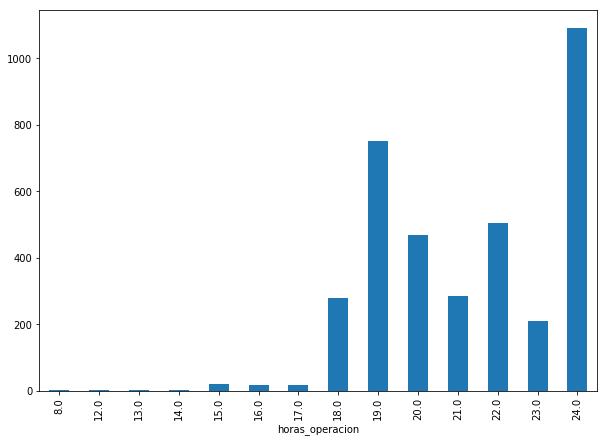

In [4]:
print("Distribución de los valores en columna horas operacion:")
data.groupby('horas_operacion')['horas_operacion'].count().plot(kind = "bar", figsize = (10, 7))

Distribución de los valores en columna pos en uso:


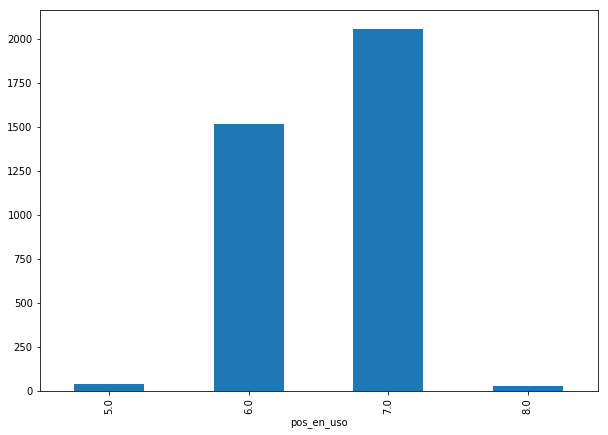

In [5]:
print("Distribución de los valores en columna pos en uso:")
data.groupby('pos_en_uso')['pos_en_uso'].count().plot(kind = "bar", figsize = (10, 7))

# TODO?

TODO


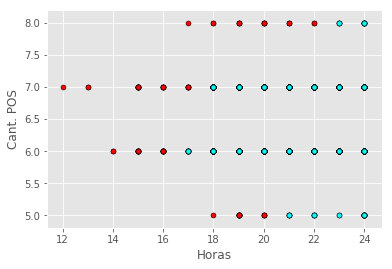

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import numpy as np
def plot_points(data):
    X = np.array(data[["horas_operacion", "pos_en_uso"]])
    y = np.array(data["volumen"])
    alto = X[np.argwhere(y == "alto")]
    bajo = X[np.argwhere(y == "medio")]
    plt.scatter([s[0][0] for s in bajo], [s[0][1] for s in bajo], s = 25, color = 'red', edgecolor = 'k')
    plt.scatter([s[0][0] for s in alto], [s[0][1] for s in alto], s = 25, color = 'cyan', edgecolor = 'k')
    plt.xlabel('Horas')
    plt.ylabel('Cant. POS')
    
plot_points(data)
print("TODO") #TODO Que representa este grafico?
plt.show()

# Pre-Procesado

## Convertir features de texto en numéricos (pero aún categóricos)

In [0]:
df = data.copy()  #Creamos una copia para mantener el DF original intacto
df['dia_de_la_semana'] = data['dia_de_la_semana'].replace(
    {'Lunes' : 0, 'Martes' : 1, 'Miercoles' : 2, 'Jueves' : 3, 'Viernes' : 4, 'Sabado' : 5, 'Domingo' : 6}
)
df['volumen'] = data['volumen'].replace({'alto' : 0, 'medio' : 1, 'bajo' : 2})
df['es_quincena'] = data['es_quincena'].replace({' VERDADERO ' : 1, ' FALSO ' : 0})

In [8]:
#Este caso especial primero cambiamos la palabra NO por un 0 y luego cambiamos cualquier otro valor por un 1
df['es_feriado'] = data['es_feriado'].replace({' NO ': 0})
df['es_feriado'] = df['es_feriado'].where(df['es_feriado'] == 0, other = 1)
df['es_feriado'].head(5)
print("Verificar resultado final:")
df.head(10)

Verificar resultado final:


,id_tienda,tipo_tienda,provincia,supervisor,fecha,dia_del_mes,mes_del_anio,semana_del_anio,es_quincena,es_feriado,dia_de_la_semana,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,volumen
0,xyz,FS,SAN JOSE,2015622_080,01/01/2009,1,1,1,1,1,3.0,17.0,6.0,385.0,167.0,1.0
1,xyz,FS,SAN JOSE,2015622_080,02/01/2009,2,1,1,1,0,4.0,19.0,7.0,400.0,147.0,1.0
2,xyz,FS,SAN JOSE,2015622_080,03/01/2009,3,1,1,1,0,5.0,20.0,6.0,409.0,166.0,1.0
3,xyz,FS,SAN JOSE,2015622_080,04/01/2009,4,1,2,0,0,6.0,19.0,6.0,455.0,185.0,1.0
4,xyz,FS,SAN JOSE,2015622_080,05/01/2009,5,1,2,0,0,0.0,19.0,7.0,301.0,83.0,1.0
5,xyz,FS,SAN JOSE,2015622_080,06/01/2009,6,1,2,0,0,1.0,18.0,7.0,307.0,94.0,1.0
6,xyz,FS,SAN JOSE,2015622_080,07/01/2009,7,1,2,0,0,2.0,19.0,7.0,305.0,95.0,1.0
7,xyz,FS,SAN JOSE,2015622_080,08/01/2009,8,1,2,0,0,3.0,19.0,7.0,288.0,75.0,1.0
8,xyz,FS,SAN JOSE,2015622_080,09/01/2009,9,1,2,0,0,4.0,20.0,6.0,372.0,98.0,1.0
9,xyz,FS,SAN JOSE,2015622_080,10/01/2009,10,1,2,0,0,5.0,19.0,6.0,446.0,189.0,1.0


## Eliminar outliers

Las variables que nos interesan son las de cantidad de clientes, comparamos clientes totales vs. VIP para cada día y decidimos borrar aquellos valores que exceden la norma, que dentro del conjunto de datos no iban a aportar mayor detalle.

Tamaño original: (3652, 16)
Tamaño después de borrado: (2383, 16)


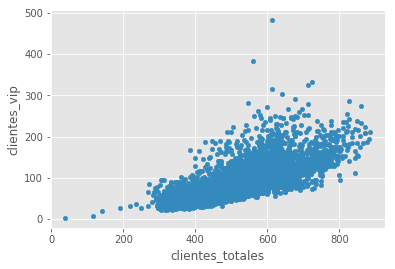

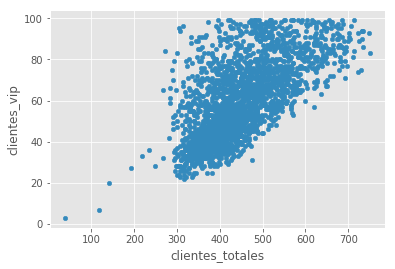

In [9]:
df.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')
print("Tamaño original:", df.shape)
df1 = df[df.clientes_vip < 100]
df1 = df1[df1.clientes_totales < 800]
print("Tamaño después de borrado:", df1.shape)
df1.plot.scatter(x = 'clientes_totales', y = 'clientes_vip')

## Convertir datos categóricos - One-hot encoding

In [10]:
# One-hot encoding
df2 = pd.get_dummies(df1, columns=['mes_del_anio', 'dia_de_la_semana', 'volumen'])
df2.head()



,id_tienda,tipo_tienda,provincia,supervisor,fecha,dia_del_mes,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
4,xyz,FS,SAN JOSE,2015622_080,05/01/2009,5,2,0,0,19.0,7.0,301.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,xyz,FS,SAN JOSE,2015622_080,06/01/2009,6,2,0,0,18.0,7.0,307.0,94.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6,xyz,FS,SAN JOSE,2015622_080,07/01/2009,7,2,0,0,19.0,7.0,305.0,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,xyz,FS,SAN JOSE,2015622_080,08/01/2009,8,2,0,0,19.0,7.0,288.0,75.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,xyz,FS,SAN JOSE,2015622_080,09/01/2009,9,2,0,0,20.0,6.0,372.0,98.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


## Normalizar features horas_operacion y pos_en_uso

In [11]:
# Normalizando horas_operacion y pos_en_uso para el intervalo 0 a 1
df2["horas_operacion"] = df2["horas_operacion"]/24
df2["pos_en_uso"] = df2["pos_en_uso"]/10
df2.head(10)

,id_tienda,tipo_tienda,provincia,supervisor,fecha,dia_del_mes,semana_del_anio,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
4,xyz,FS,SAN JOSE,2015622_080,05/01/2009,5,2,0,0,0.791667,0.7,301.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,xyz,FS,SAN JOSE,2015622_080,06/01/2009,6,2,0,0,0.750000,0.7,307.0,94.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6,xyz,FS,SAN JOSE,2015622_080,07/01/2009,7,2,0,0,0.791667,0.7,305.0,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,xyz,FS,SAN JOSE,2015622_080,08/01/2009,8,2,0,0,0.791667,0.7,288.0,75.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,xyz,FS,SAN JOSE,2015622_080,09/01/2009,9,2,0,0,0.833333,0.6,372.0,98.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
11,xyz,FS,SAN JOSE,2015622_080,12/01/2009,12,3,0,0,0.750000,0.6,297.0,65.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
12,xyz,FS,SAN JOSE,2015622_080,13/01/2009,13,3,1,0,0.750000,0.6,363.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
13,xyz,FS,SAN JOSE,2015622_080,14/01/2009,14,3,1,0,0.750000,0.7,344.0,89.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
18,xyz,FS,SAN JOSE,2015622_080,19/01/2009,19,4,0,0,0.750000,0.7,323.0,57.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
19,xyz,FS,SAN JOSE,2015622_080,20/01/2009,20,4,0,0,0.750000,0.6,356.0,69.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


## Borrar NaNs

In [12]:
print ("Shape antes: ", df2.shape)
print ("Hay Nans? ", df2.isnull().values.any())   #preguntar si hay NaN
# remove NaNs
df2 = df2.dropna()
print ("Shape después: ", df2.shape)

Shape antes:  (2383, 35)
Hay Nans?  True
Shape después:  (2381, 35)


## Elección de columnas (features)

Para este corte se elimina todas las columnas que brindan info específica de tiendas pues solamente se analizará una tienda.

La columna semana del año y mes del año no brindan mayor información en conjunto, es posible que sean redundantes por lo que probaremos removiendo una de ellas.

In [13]:
cols_to_drop = ['id_tienda', 'tipo_tienda', 'provincia', 'supervisor', 'semana_del_anio']

processed = df2.drop(cols_to_drop, 1)
print("Tamaño post-procesamiento:", processed.shape)
processed.head(5)

Tamaño post-procesamiento: (2381, 30)


,fecha,dia_del_mes,es_quincena,es_feriado,horas_operacion,pos_en_uso,clientes_totales,clientes_vip,mes_del_anio_1,mes_del_anio_2,mes_del_anio_3,mes_del_anio_4,mes_del_anio_5,mes_del_anio_6,mes_del_anio_7,mes_del_anio_8,mes_del_anio_9,mes_del_anio_10,mes_del_anio_11,mes_del_anio_12,dia_de_la_semana_0.0,dia_de_la_semana_1.0,dia_de_la_semana_2.0,dia_de_la_semana_3.0,dia_de_la_semana_4.0,dia_de_la_semana_5.0,dia_de_la_semana_6.0,volumen_0.0,volumen_1.0,volumen_2.0
4,05/01/2009,5,0,0,0.791667,0.7,301.0,83.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
5,06/01/2009,6,0,0,0.750000,0.7,307.0,94.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
6,07/01/2009,7,0,0,0.791667,0.7,305.0,95.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,08/01/2009,8,0,0,0.791667,0.7,288.0,75.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
8,09/01/2009,9,0,0,0.833333,0.6,372.0,98.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


# Inicia el trabajo con los modelos elegidos, que serán:
   **DecisionTree**

   **RandomForest**
   
   **Redes Neuronales ANN**

In [14]:
# Splitting the data input into X, and the labels y 
X = np.array(processed)[:,0:18]
X = X.astype('float32')
y = keras.utils.to_categorical(df1["volumen"],3)

ValueError: ignored

Determinar cuáles columnas son features y cuáles labels.

En este caso las clases están dadas por "volumen" que indica si es un día alto volumen (cantidad de clientes), medio o bajo

In [0]:

# Splitting the data input into X, and the labels y 
features = np.array(processed)[:,0:18]
features = features.astype('float32')
labels = keras.utils.to_categorical(df1["volumen"],3)

print("Shape of features:", features.shape)
print("\nShape of labels:", labels.shape)
print("\nFirst 5 rows of features")
print(features[:5])
print("\nFirst 5 rows of labels")
print(labels[:5])



Separa set de entrenamiento y set de pruebas
Con una proporción 75% - 25%

In [0]:
X_train,X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state = 13) 

In [0]:
print ("shape del dataset completo: ", processed.shape)
print ("\nshape del set de entrenamiento: ", X_train.shape)
print ("\nshape del set de pruebas: ", y_test.shape)

## Modelo clasificador usando DecisionTree

In [0]:
DecisionTreeModel = DecisionTreeClassifier(max_depth=10,min_samples_leaf=12)

#entrenamiento
print(DecisionTreeModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = DecisionTreeModel.predict(X_test)

print("\nAccuracy para DecisionTree: {:.4f}".format(accuracy_score(y_test, y_predict)))

## Modelo clasificador usando RandomForest

In [0]:
RandomForestModel = RandomForestClassifier(min_samples_leaf=3, min_samples_split=10, n_estimators=290, max_depth = 14, random_state = 10)

#entrenamiento
print(RandomForestModel.fit(X_train, y_train))

#prediccion (usar datos de test)
y_predict = RandomForestModel.predict(X_test)

print("\nAccuracy para Random Forest:     {:.4f}".format(accuracy_score(y_test, y_predict)))

## Modelo clasificador usando ANN

In [0]:
#FALTA...